In [49]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
import numpy as np
import time
from torch.utils.tensorboard import SummaryWriter  # to print to tensorboard
import torchvision
import matplotlib.pyplot as plt

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
transforms = transforms.Compose(
[transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))]
)
trainset = MNIST('../MNIST/datasets/',train=True,transform=transforms,download=True)
testset = MNIST('../MNIST/datasets/',train=False,transform=transforms,download=True)

In [4]:
trainset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../MNIST/datasets/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

In [34]:
class Discrimator(nn.Module):
    def __init__(self):
        super(Discrimator,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=8,kernel_size=(3,3),padding=(1,1))
        self.pool = nn.MaxPool2d(kernel_size=(2,2),stride=(2,2))
        self.conv2 = nn.Conv2d(in_channels=8,out_channels=16,kernel_size=(3,3),padding=(1,1))
        self.fc = nn.Linear(16*7*7,1)
    def forward(self,x):
        x = F.leaky_relu(self.conv1(x))
#         print(x.shape)
        x = self.pool(x)
#         print(x.shape)
        x = F.leaky_relu(self.conv2(x))
#         print(x.shape)
        x = self.pool(x)
#         print(x.shape)
        x = x.reshape(x.shape[0],-1)
        x = self.fc(x)
#         print(x.shape)
        x = torch.sigmoid(x)
        return x
    
class Generator(nn.Module):
    def __init__(self,z_dims):
        super(Generator,self).__init__()
        self.fc1 = nn.Linear(z_dims,196)
        self.conv1 = nn.ConvTranspose2d(in_channels=1,out_channels=8,kernel_size=(2,2),stride=(2,2))
        self.conv2 = nn.ConvTranspose2d(in_channels=8,out_channels=1,kernel_size=(1,1))
        
    def forward(self,x):
        x = F.leaky_relu(self.fc1(x))
#         print(x.shape)
        x = x.reshape(x.shape[0],14,14)
#         print(x.shape)
        x = x.unsqueeze(1)
#         print(x.shape)
        x = F.leaky_relu(self.conv1(x))
#         print(x.shape)
        x = F.leaky_relu(self.conv2(x))
#         print(x.shape)
        return x

In [35]:
dis = Discrimator().to(device)
gen = Generator(64).to(device)
# y = torch.rand(1,64).to(device)
# model(y)

In [40]:
trainloader = DataLoader(trainset,batch_size=64,shuffle=True,num_workers=5)
opt_dis = torch.optim.Adam(dis.parameters(),lr=3e-4)
opt_gen = torch.optim.Adam(gen.parameters(),lr=3e-4)
criterion = nn.BCELoss()
writer_fake = SummaryWriter(f"logs/fake")
writer_real = SummaryWriter(f"logs/real")

Epoch [0/2] Batch 0/938                       Loss D: 0.0000, loss G: 15.9381


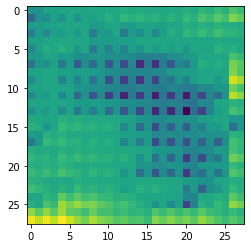

Epoch [1/2] Batch 0/938                       Loss D: 0.0000, loss G: 16.4551


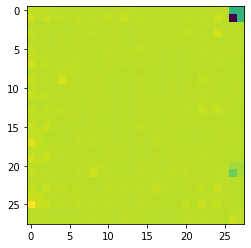

Epoch [2/2] Batch 0/938                       Loss D: 0.0000, loss G: 16.9699


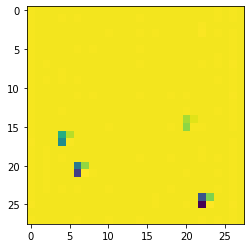

Epoch [3/2] Batch 0/938                       Loss D: 0.0000, loss G: 17.4804


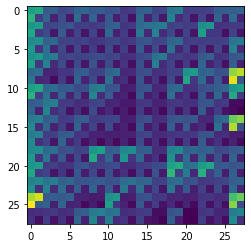

Epoch [4/2] Batch 0/938                       Loss D: 0.0000, loss G: 17.9922


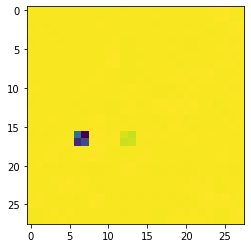

Epoch [5/2] Batch 0/938                       Loss D: 0.0000, loss G: 18.4984


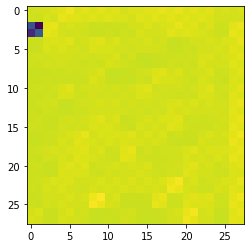

Epoch [6/2] Batch 0/938                       Loss D: 0.0000, loss G: 19.0031


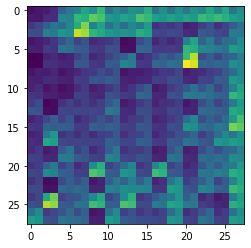

Epoch [7/2] Batch 0/938                       Loss D: 0.0000, loss G: 19.5079


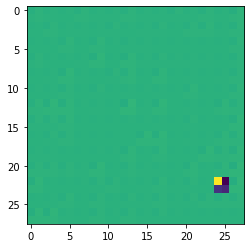

Epoch [8/2] Batch 0/938                       Loss D: 0.0000, loss G: 20.0061


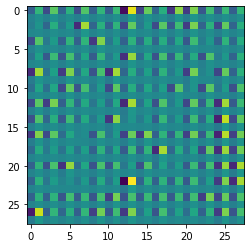

Epoch [9/2] Batch 0/938                       Loss D: 0.0000, loss G: 20.5032


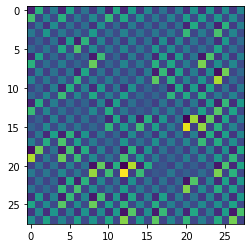

In [54]:
step = 0
for epoch in range(10):
    for batch_idx, (real, _) in enumerate(trainloader):
        batch_size = real.shape[0]
        real = real.to(device)

        ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        noise = torch.randn(batch_size, 64).to(device)
        fake = gen(noise)
        
        disc_real = dis(real)
#         print(disc_real.shape)
        lossD_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = dis(fake)
        lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        lossD = (lossD_real + lossD_fake) / 2
        
        opt_dis.zero_grad()
        
        lossD.backward(retain_graph=True)
        opt_dis.step()

#         ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
#         # where the second option of maximizing doesn't suffer from
#         # saturating gradients
        
        output = dis(fake)
        lossG = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        lossG.backward()
        opt_gen.step()
        if batch_idx == 0:
            print(
                f"Epoch [{epoch}/{2}] Batch {batch_idx}/{len(trainloader)} \
                      Loss D: {lossD:.4f}, loss G: {lossG:.4f}"
            )

            with torch.no_grad():
                fake = gen(noise).reshape(-1, 1, 28, 28)
                plt.imshow(fake[0].permute(1,2,0).cpu())
                plt.show()
                data = real.reshape(-1, 1, 28, 28)
                img_grid_fake = torchvision.utils.make_grid(fake, normalize=True)
                img_grid_real = torchvision.utils.make_grid(data, normalize=True)

                writer_fake.add_image(
                    "Mnist Fake Images", img_grid_fake, global_step=step
                )
                writer_real.add_image(
                    "Mnist Real Images", img_grid_real, global_step=step
                )
                step += 1


In [32]:
noise.shape

torch.Size([64, 64])

In [33]:
gen(noise)